<h1> Ensemble script for FATES-SP runs </h1>

This script will 

<ol>
<li>Clone github repo and move to CLM-FATES-SP pull request branchs
<li>Make a default 4x5 CLM-FATES-SP case
<li>Make an ensemble of CLM-FATES-SP cases 
<li>Generate an ensemble of parameter files with one at a time modification
<li>Point each ensemble member at a different parameter file
<li>Submit all these jobs
<li>Analyse output
</ol>

<h4>n.b. 1. Most of the decisions here on compsets, FATES options, resolution, variables etc. are easy to modify. </h4>
<h4>n.b. 2. This notebook is also set up to work with Cheyenne specific paths. Making it machine agnostic is tbd.</h4>

<h3>Set global variables and paths for ensemble analysis </h3>

In [1]:
#set global variables to pass into BASH commands. 

ctsmrepo='ctsmmar21'
defbuildroot='/glade/scratch/'
clmparamfiledefault = 'clmparamsdef.nc'
#Settings for the SP ensemble
sp=1
noc4=1
hydro=0
calib=1
n=8
dim3=1

In [2]:
if(sp == 1):
    resub=0
    ncases=14
    ychoose =2009
    defcase='SPdefault_mar'
    defbuildroot='/glade/scratch/'
    if(noc4 == 1):
        ens_directory='SPfates_ens_noc4'
        caseroot='spfates_noc4_n3_'
        paramsdir='param_files_sp_mar_noc4'
        paramfiledefault='fates_params_default_noc4.nc'
        if(hydro == 1):
            ens_directory='SPfates_ens_noc4_hydro'
            caseroot='spfates_noc4_hydro_n'
            paramsdir='param_files_sp_noc4_hydro'
            paramfiledefault='fates_params_default_noc4.nc' 
        if(calib == 1):
            ens_directory='SPfates_ens_n'+str(n)+'_noc4'
            caseroot='spfates_noc4_n'+str(n)+'_'
            paramsdir='param_files_sp_n'+str(n)+'_noc4'
            paramfiledefault='fates_params_default_noc4.nc'            
            ncases=125
    else:
        ens_directory='SPfates_ens'
        caseroot='spfates_01_n'
        paramsdir='param_files_sp'
        paramfiledefault='fates_params_default.nc'
else:
#Settings for the NOCOMP ensemble. 
#set global variables to pass into BASH commands. 
    sp=0
    defcase='SPdefault_mar'
    ens_directory='NOCOMP_fates_ens_'+str(n)
    caseroot='nocomp_fates_'+str(n)+'_'
    paramsdir='param_files_nocomp_'+str(n)
    paramfiledefault='/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n6_noc4/calib_paramfiledefault.nc'
    resub=2
    ncases=14
    ychoose =2009
print(paramsdir)
print(sp)
print(ncases)
print(caseroot)

param_files_sp_n8_noc4
1
125
spfates_noc4_n8_


<h3> Control variables for the analysis script.</h3>

In [3]:
dosubmit=0
forcenewcase=0
doanalysis=1

In [4]:
import os
notebookdr=os.getcwd() 
fault='fates_params_default_n3_noc4.nc'


In [5]:
defclmparams= '/glade/p/cesmdata/cseg/inputdata/lnd/clm2/paramdata/clm5_params.c200402.nc'

<h3>Clone CTSM repo, switch to SP pull request code.</h3>

In [6]:
%%bash -s "$ctsmrepo"
ctsmrepo=$1
echo $ctsmrepo

cd /glade/work/$USER/
#go to git directory
if [[ -d "git" ]]
then
cd git/
else
mkdir git
cd git
fi
echo pwd

#go to git repo, or checkout code
if [[ -d "$ctsmrepo" ]]
then
cd $ctsmrepo
else

#clone CTSM code
git clone https://github.com/escomp/ctsm $ctsmrepo
cd $ctsmrepo
./manage_externals/checkout_externals
cd src

#change CTSM code to SP branch. 
git remote add  rosie_ctsm_repo  https://github.com/rosiealice/ctsm
git fetch rosie_ctsm_repo
git checkout -b SP_api rosie_ctsm_repo/SP_api

#change FATES code to SP branch. 
cd fates
git remote add  rosie_fates_repo https://github.com/rosiealice/fates
git fetch rosie_fates_repo
git checkout -b fates_sp_sept rosie_fates_repo/fates_sp_sept
fi

ctsmmar21
pwd


<h3> Make a default FATES 4x5 case </h3>

In [7]:
%%bash -s "$ctsmrepo" "$defcase"

ctsmrepo=$1
defcase=$2

cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
pwd
if [[ -d "$defcase" ]]
then
    echo "$defcase exists on your filesystem."
else

./create_newcase --case $defcase --compset 2000_DATM%GSWP3v1_CLM50%FATES_SICE_SOCN_MOSART_CISM2%NOEVOLVE_SWAV_SIAC_SESP --res f45_f45_mg37  --run-unsupported
cd $defcase
./case.setup
./case.build
fi


/glade/work/rfisher/git/ctsmmar21/cime/scripts
SPdefault_mar exists on your filesystem.


<h3> Adjust settings of default case. </h3>

In [8]:
%%bash -s "$ctsmrepo" "$defcase" "$defbuildroot" 

ctsmrepo=$1
defcase=$2
defbuildroot=$3

defbld=$defbuildroot$USER/$defcase/bld
echo $defbld
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts/$defcase

echo 'updating settings',$newcase
./xmlchange BUILD_COMPLETE=TRUE;
./xmlchange EXEROOT=$defbld;
./xmlchange CONTINUE_RUN=FALSE;
./xmlchange --id STOP_N --val 5;
./xmlchange --id STOP_OPTION --val nyears;
./xmlchange --id CLM_FORCE_COLDSTART --val on;


/glade/scratch/rfisher/SPdefault_mar/bld
updating settings,
For your changes to take effect, run:
./case.build --clean-all
./case.build
For your changes to take effect, run:
./case.build --clean-all
./case.build


<h3> Make Default user_nl_clm File </h3>

In [9]:
%%bash -s "$ctsmrepo" "$defcase" "$notebookdr" "$paramsdir" "$hydro" "$sp"

ctsmrepo=$1
echo $ctsmrepo
defcase=$2
notebookdr=$3
paramsdir=$4
hydro=$5
sp=$6

echo $sp

echo $notebookdr/$paramsdir/

cd $notebookdr
if [[ -d "$paramsdir" ]]
then
   echo "existing param firectory"
else 
    mkdir $paramsdir
    echo "made param firectory"
fi
pwd

echo $paramsdir
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
pwd
cp  $defcase/user_nl_clm $notebookdr/$paramsdir/user_nl_clm_default

cd $notebookdr
cd $paramsdir
pftfilename_def=$notebookdr/$paramsdir

if [ $sp -eq 1 ]
then
echo use_fates_sp=.true. >> user_nl_clm_default
fi

echo use_fates_nocomp=.true. >> user_nl_clm_default
echo use_fates_fixed_biogeog=.true. >> user_nl_clm_default
echo fates_paramfile=\'\pftfilename_default\' >> user_nl_clm_default
echo paramfile=\'\clmfilename_default\' >> user_nl_clm_default 
 
if [ $hydro -eq 1 ]
then
echo use_fates_planthydro=.true. >> user_nl_clm_default
fi

cat  $notebookdr/$paramsdir/user_nl_clm_default

ctsmmar21
1
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/
existing param firectory
/glade/u/home/rfisher/fates_sp_ensembles
param_files_sp_n8_noc4
/glade/work/rfisher/git/ctsmmar21/cime/scripts
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state       by the CLM_BLDNML_OPTS -bgc_spinup      setting
! Set co2_ppmv           with CCSM_CO2_PPMV                      option
! Set dtime              with L_NCPL                            

<h3> Make ensemble of cases.</h3>

In [10]:
%%bash -s "$ctsmrepo" "$defcase" "$ens_directory" "$caseroot" $ncases "$forcenewcase"

ctsmrepo=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
forcenewcase=$6

echo $ncases
echo $caseroot
echo $ens_directory
echo $ctsmrepo

cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
pwd

if [[ -d "$ens_directory" ]]
then
echo "directory already exists"
else
mkdir $ens_directory
fi 

counter1=0 #include a default zero case. 
while [ $counter1 -le $ncases ]
do
  newcase=$caseroot$counter1
  rm -rf $newcase 
  if [ -d $ens_directory/$newcase ]
  then
    echo ' new case already exists',$ens_directory/$newcase   
  else
   echo 'making', $newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
    cd $ens_directory/$newcase 
    ./case.setup;
    cd ../../
  fi
  if [ $forcenewcase -eq 1 ]
  then
   echo 'force making', $ens_directory/$newcase
    rm -rf $ens_directory/$newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
    cd $ens_directory/$newcase
    ./case.setup;
    cd ../../
  fi

  ((counter1++))
  done    


125
spfates_noc4_n8_
SPfates_ens_n8_noc4
ctsmmar21
/glade/work/rfisher/git/ctsmmar21/cime/scripts
directory already exists
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_0
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_1
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_2
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_3
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_4
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_5
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_6
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_7
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_8
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_9
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_10
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_11
 new case already exists,SPfates_ens_n8_noc4/spfates_noc4_n8_12
 new case already exists,SPfates_ens_n8_noc4/spfates_no

<h3> Create .nc version of current defualt file. I FAILED ATT THIS. NEEDS INPUT..</h3>
You currently have to do this step manually, by doing this in the terminal:

<i> cd /glade/work/$USER/git/$ctsmrepo/src/fates/parameter_files/</i><br>
<i>ncgen -o fates_params_default.nc fates_params_default.cdl </i>

<h3> Make a directory for the parameter files to go in and copy default .nc parameter file there. </h3>

In [11]:
%%bash -s "$ctsmrepo" "$notebookdr"  "$paramsdir" "$paramfiledefault" "$sp"
echo $1
ctsmrepo=$1
notebookdr=$2
paramsdir=$3
paramfiledefault=$4
sp=$5
echo $ctsmrepo
echo $sp

cd $notebookdr
if [[ -d "$paramsdir" ]]
then
   cd $paramsdir
   echo "existing param firectory"
else 
    mkdir $paramsdir
    cd $paramsdir
    echo "made param firectory"
fi
pwd
echo $paramfiledefault
if [ $sp -eq 1 ]
then
    cp /glade/work/$USER/git/$ctsmrepo/src/fates/parameter_files/$paramfiledefault $paramfiledefault
else
    cp $paramfiledefault .
fi

ctsmmar21
ctsmmar21
1
existing param firectory
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4
fates_params_default_noc4.nc


<h3>Modify default FATES parameter file</h3>

In [12]:
import netCDF4 as nc4
import sys
import os
import shutil


def copy_clobber(filename1, filename2):
    try:
        os.remove(filename2)
        print('replacing file: '+filename2)
    except:
        print('file does not yet exist: '+filename2)
    shutil.copyfile(filename1, filename2)

if( sp == 1):
    filename_template = notebookdr+'/'+paramsdir+'/'+paramfiledefault
    print(' file: '+filename_template)
else:
    filename_template = paramfiledefault


if(calib == 1):
    calibration_file='default_spcalib_0312.nc'
    filename_calib = notebookdr+'/'+paramsdir+'/'+calibration_file
    shutil.copyfile(filename_template, filename_calib)
    filename_template=filename_calib
    #modify template file
    fin = nc4.Dataset(filename_calib, 'r+')
    print(filename_calib)
    
    #gs1 = fin.variables['fates_leaf_stomatal_slope_ballberry']
    #increase overall ET by shifting gs1 from 8 to 10
   # gs1[:] = gs1[:] * 11/8
    #make is lower in savanna
    #gs1[4] = 5 #savanna
    #gs1[10] = 5 #c3g
    
    vcm = fin.variables['fates_leaf_vcmax25top']
    #decrease boreal GPP
    print(vcm[0,0])
    #vcm[0,1]=vcm[0,1] *0.6 #NET
    #vcm[0,2]=vcm[0,2] *0.6 #CDT
    #vcm[0,9]=vcm[0,9] *0.6 #C3AG
    
    #increase BET GPP. 
    #vcm[0,0]=vcm[0,0] *0.8 #BET

    
  #  dl = fin.variables['fates_leaf_diameter']
    #increase ET by means of leaf diameter. 
    #dl[:]=dl[:]*0.5
    
    #cl = fin.variables['fates_leaf_clumping_index']
   # cl[:] = cl[:] * 0.8
    
    fin.close()   

print(filename_template)

 file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/fates_params_default_noc4.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/default_spcalib_0312.nc
50.0
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/default_spcalib_0312.nc


<h3> Modify ensemble of parameters<h3>

In [13]:
import numpy as np
def def_pftfile(notebookdr, paramsdir,i,variable,delta):
    filename_out= notebookdr+'/'+paramsdir+'/fates_params_update_'+str(i)+'.nc'
        
    print('out fn: ',filename_out)
    copy_clobber(filename_template,filename_out)

    fin = nc4.Dataset(filename_out, 'r+')
    var = fin.variables[variable]
    var[:] = var[:]*delta
    fin.close()
    
vs=range(0,ncases+1) 
print(vs)
count=1


if(sp == 1): 
    if( calib == 0):
        for i in vs:
            def_pftfile(notebookdr, paramsdir,i,'fates_leaf_clumping_index',1.0)


        def_pftfile(notebookdr, paramsdir,1,'fates_leaf_clumping_index',0.9)
        def_pftfile(notebookdr, paramsdir,2,'fates_leaf_clumping_index',1.1)

        def_pftfile(notebookdr, paramsdir,3,'fates_leaf_diameter',0.1)
        def_pftfile(notebookdr, paramsdir,4,'fates_leaf_diameter',10.0)
    
        def_pftfile(notebookdr, paramsdir,5,'fates_leaf_stomatal_slope_ballberry',0.8)
        def_pftfile(notebookdr, paramsdir,6,'fates_leaf_stomatal_slope_ballberry',1.2)

        def_pftfile(notebookdr, paramsdir,7,'fates_leaf_vcmax25top',0.8)
        def_pftfile(notebookdr, paramsdir,8,'fates_leaf_vcmax25top',1.2)

        def_pftfile(notebookdr, paramsdir,9,'fates_displar',0.8)
        def_pftfile(notebookdr, paramsdir,10,'fates_displar',1.2)
    
        def_pftfile(notebookdr, paramsdir,11,'fates_z0mr',0.8)
        def_pftfile(notebookdr, paramsdir,12,'fates_z0mr',1.2)

        def_pftfile(notebookdr, paramsdir,13,'fates_smpsc',0.5)
        def_pftfile(notebookdr, paramsdir,14,'fates_smpsc',1.5)
    
    else: #space exploration/calibration mode
        for i in range(0,ncases+1):
            def_pftfile(notebookdr, paramsdir,i,'fates_leaf_clumping_index',1.0)
        
        gs=range(0,5)
        vs=range(0,5)
        ds=range(0,5)
        gsarr=[4,6,8,10,12]
        vcarr=[30,45,60,75,90]
        dlarr=[0.0004,0.001,0.004,0.01,0.04] #nb that this cannot be PFT dependant in its usage thus far. 
        vcarrpftmin=[23.6,37.8,28,33.7,36.5,36.5,37.1,39.5,39.5,47.1,47.1,20]
        vcarrpftmax=[46.4, 87.2, 50.2, 89.1, 78.9, 78.9, 86.3, 68.5, 68.5, 109.3, 109.3, 40]
        
        counter=1
        gi=np.empty([ncases+1], dtype=int)
        vi=np.empty([ncases+1], dtype=int)
        di=np.empty([ncases+1], dtype=int)
        gval=np.empty([ncases+1])
        vval=np.empty([ncases+1])
        dval=np.empty([ncases+1])
        
        for g in gs:
            for d in ds:
                for v in vs:
                    gi[counter]=g
                    di[counter]=d
                    vi[counter]=v
                    gval[count]=gsarr[g]
                    dval[count]=dlarr[d]
                    vval[count]=vcarr[v]
                    print(gi[counter],di[counter])
                    filename_out= notebookdr+'/'+paramsdir+'/fates_params_update_'+str(counter)+'.nc'
                    #print(filename_out)
                    counter=counter+1
                    print(counter,g,v,d)
                    fin = nc4.Dataset(filename_out, 'r+')
                    
                    gs1 = fin.variables['fates_leaf_stomatal_slope_ballberry']
                    gs1[:] = gs1[:]*0+gsarr[g]
                    vcm = fin.variables['fates_leaf_vcmax25top']
                    vcm[:] = vcm[:]*0+vcarr[v]
                    dlm = fin.variables['fates_leaf_diameter']
                    dlm[:] = dlm[:]*0+dlarr[d]

                    fin.close()
        print(dval)

else: #(sp==0)
    print('template: ',filename_template)
    for i in vs:
        def_pftfile(notebookdr, paramsdir,i,'fates_leaf_clumping_index',1.0)

    def_pftfile(notebookdr, paramsdir,1,'fates_prt_nitr_stoich_p1',0.8)
    def_pftfile(notebookdr, paramsdir,2,'fates_prt_nitr_stoich_p1',1.2)

    def_pftfile(notebookdr, paramsdir,3,'fates_allom_l2fr',0.8)
    def_pftfile(notebookdr, paramsdir,4,'fates_allom_l2fr',1.2)

    def_pftfile(notebookdr, paramsdir,5,'fates_allom_la_per_sa_int',0.8)
    def_pftfile(notebookdr, paramsdir,6,'fates_allom_la_per_sa_int',1.2)

    def_pftfile(notebookdr, paramsdir,7,'fates_allom_d2bl1',0.8)
    def_pftfile(notebookdr, paramsdir,8,'fates_allom_d2bl1',1.2)

    def_pftfile(notebookdr, paramsdir,9,'fates_allom_d2ca_coefficient_min',0.8)
    def_pftfile(notebookdr, paramsdir,10,'fates_allom_d2ca_coefficient_min',1.2)

    def_pftfile(notebookdr, paramsdir,11,'fates_leaf_long',0.8)
    def_pftfile(notebookdr, paramsdir,12,'fates_leaf_long',1.2)

    def_pftfile(notebookdr, paramsdir,13,'fates_root_long',0.5)
    def_pftfile(notebookdr, paramsdir,14,'fates_root_long',1.5)
    
    
    

range(0, 126)
out fn:  /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/fates_params_update_0.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/fates_params_update_0.nc
out fn:  /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/fates_params_update_1.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/fates_params_update_1.nc
out fn:  /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/fates_params_update_2.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/fates_params_update_2.nc
out fn:  /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/fates_params_update_3.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/fates_params_update_3.nc
out fn:  /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/fates_params_update_4.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_n

<h3>Modify default CLM parameter file</h3>

In [14]:
import netCDF4 as nc4
import sys
import os
import shutil

shutil.copyfile(defclmparams, clmparamfiledefault) 

filename_template = clmparamfiledefault

print(filename_template)

def def_pftfile(notebookdr, paramsdir,i,variable,delta):
    filename_out= notebookdr+'/'+paramsdir+'/clm_params_update_'+str(i)+'.nc'
    copy_clobber(filename_template,filename_out)
    fin = nc4.Dataset(filename_out, 'r+')
    var = fin.variables[variable]
    var[:] = var[:]*delta
    fin.close()
    
#Make a set of CLM files to modify if needed. 
vs=range(0,ncases+1) 
for i in vs:
    def_pftfile(notebookdr, paramsdir,i,'fff',1.0)
    

clmparamsdef.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/clm_params_update_0.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/clm_params_update_1.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/clm_params_update_2.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/clm_params_update_3.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/clm_params_update_4.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/clm_params_update_5.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/clm_params_update_6.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/clm_params_update_7.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n8_noc4/clm_params_update_8.nc
replacing file: /glade/u/home/rfisher/fates_sp_ensembles/

<h3> Point each ensemble script at different parameter file </h3>

In [15]:
%%bash -s "$ctsmrepo" "$defcase" "$ens_directory" "$caseroot" $ncases "$notebookdr"  "$paramsdir"

ctsmrepo=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
forcenewcase=1
notebookdir=$6
paramsdir=$7

unl=user_nl_clm
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
counter1=0
cd $ens_directory
#cat $notebookdir/$paramsdir/user_nl_clm_default
while [ $counter1 -le $ncases ]
do
  newcase=$caseroot$counter1
  pftfilename=$notebookdir/$paramsdir/fates_params_update_$counter1.nc
  clmfilename=$notebookdir/$paramsdir/clm_params_update_$counter1.nc
  if [ -d $newcase ]
  then
   cd $newcase
   #get default parameter file
    cp $notebookdir/$paramsdir/user_nl_clm_default user_nl_clm
    sed -i "s|pftfilename_default|$pftfilename|g" user_nl_clm
    sed -i "s|clmfilename_default|$clmfilename|g" user_nl_clm
    cd ../
  else
   echo 'no case', $newcase
  fi


  ((counter1++))
  done
cat $newcase/user_nl_clm

!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state       by the CLM_BLDNML_OPTS -bgc_spinup      setting
! Set co2_ppmv           with CCSM_CO2_PPMV                      option
! Set dtime              with L_NCPL                             option
! Set fatmlndfrc         with LND_DOMAIN_PATH/LND_DOMAIN_FILE    options
! Set finidat            with RUN_REFCASE/RUN_REFDATE/RUN_REFTOD options for hybrid or branch cases
!                        (includ

<h3> Annoying modification of namelist variables  </h3>

In [16]:
%%bash -s "$ctsmrepo" "$defcase" "$ens_directory" "$caseroot" $ncases "$notebookdr"  "$paramsdir"

ctsmrepo=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
forcenewcase=1
notebookdir=$6
paramsdir=$7

echo $caseroot
echo $ens_directory

unl=user_nl_clm
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
cd $ens_directory

counter1=0
while [ $counter1 -le $ncases ]
do
  newcase=$caseroot$counter1
  cd $newcase
  echo maximum_leaf_wetted_fraction =0.12 >> user_nl_clm
  cd ../
  ((counter1++))
done
cat $newcase/user_nl_clm

# For specific ensemble members. 
#if[ $ncases -eq 17 ]
#then
#  counter1=17
#  newcase=$caseroot$counter1
#  cd $newcase
##  echo maximum_leaf_wetted_fraction =0.02 >> user_nl_clm
##  cd ../
#  cat $newcase/user_nl_clm

#  counter1=18
#  newcase=$caseroot$counter1
#  cd $newcase
#  echo maximum_leaf_wetted_fraction =0.12 >> user_nl_clm
#  cd ../
#fi


spfates_noc4_n8_
SPfates_ens_n8_noc4
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state       by the CLM_BLDNML_OPTS -bgc_spinup      setting
! Set co2_ppmv           with CCSM_CO2_PPMV                      option
! Set dtime              with L_NCPL                             option
! Set fatmlndfrc         with LND_DOMAIN_PATH/LND_DOMAIN_FILE    options
! Set finidat            with RUN_REFCASE/RUN_REFDATE/RUN_REFTOD options for hybrid or branch c

<h3>Submit ensemble of cases</h3>

In [17]:
print(ctsmrepo)
print(defcase)
print(ens_directory)
print(caseroot)
print(ncases)
print(dosubmit)

ctsmmar21
SPdefault_mar
SPfates_ens_n8_noc4
spfates_noc4_n8_
125
0


In [18]:
%%bash -s "$ctsmrepo" "$defcase" "$ens_directory" "$caseroot" "$ncases" "$dosubmit" 

ctsmrepo=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
dosubmit=$6

echo $ncases

startcase=0

if [ $dosubmit -eq 1 ]
then
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
echo 'submitting'
counter1=$startcase
cd $ens_directory
pwd

while [ $counter1 -le $ncases ]
do
  echo $counter1
  newcase=$caseroot$counter1
  echo $newcase

  if [ -d $newcase ]
  then
    cd $newcase
    ./case.setup
    echo 'submitting job',$newcase
    #./xmlchange BUILD_COMPLETE=TRUE
    #./xmlchange RESUBMIT=1
   # ./xmlchange PROJECT=P93300041
    ./case.submit
    cd ../
  else
   echo 'no case', $newcase
  fi

  ((counter1++))
  done
else
echo "not submitting jobs"
fi

125
not submitting jobs


<h2>Analyse output</h2>

In [19]:
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
import datetime
import cartopy
import cartopy.crs as ccrs
import os.path
import xesmf as xe

In [20]:
if doanalysis ==1: 
    titles=['clumping_index -','clumping_index +','leaf_diameter -','leaf_diameter +',
           'stomatal_slope -','stomatal_slope +','vcmax25top -','vcmax25top +',
           'leaf_xl -','leaf_xl +','rholvis -','rholvis +',    
           'smpsc -','smpsc +' ,'fff -','fff +','fwet +','fwet -']

    titles=['clumping_index -','clumping_index +','leaf_diameter -','leaf_diameter +',
           'stomatal_slope -','stomatal_slope +','vcmax25top -','vcmax25top +',
           'displar -','displar +','z0 -','z0 +',    
           'smpsc -','smpsc +' ,'fff -','fff +','fwet -','fwet +']

    if(sp == 0):
        titles =['leafn -','leafn +','r:l -','r:l +',
           'allom bl1 -','allom bl11 +','allom bl2 -','allom bl12 +', 
            'allom_ca -','allom ca +','leaflong -','leaflong +',
            'rootong -','rootong +',   ]


    output='/glade/scratch/rfisher/'
    conv = 3600*24*365
    yr='.clm2.h0.'

       
    pftnames=['BlEvTrTr','NlEvTr','NlCdDecTt','BlEvTmTr','BlDrDecTt','BlCdDecTr','BlEvSh','BlDrDecSh','BlCdDecSh','C3AG','C3G']

<h3> Get ILAMB data</h3>

In [21]:
if doanalysis ==1: 
    filenameb ='/glade/u/home/rfisher/GBAF_Benchmark.nc'
    gppbm = xr.open_dataset(filenameb,group='MeanState')

    filenameef ='/glade/u/home/rfisher/GBAF_Benchmark_EF.nc'
    efbm = xr.open_dataset(filenameef,group='MeanState')
    
    filenameef ='/glade/u/home/rfisher/GLEAM_Benchmark.nc'
    glbm = xr.open_dataset(filenameef,group='MeanState')

    filenamelai ='/glade/u/home/rfisher/MODISlai_Benchmark.nc'
    print(filenamelai)
    laibm = xr.open_dataset(filenamelai,group='MeanState')

    

/glade/u/home/rfisher/MODISlai_Benchmark.nc


<h3> Regrid ILAMB data</h3>

Create weight file: bilinear_360x720_45x72.nc
Remove file bilinear_360x720_45x72.nc
Create weight file: bilinear_360x720_45x72.nc
Remove file bilinear_360x720_45x72.nc
Create weight file: bilinear_360x720_45x72.nc
Remove file bilinear_360x720_45x72.nc
Create weight file: bilinear_360x720_45x72.nc
Remove file bilinear_360x720_45x72.nc


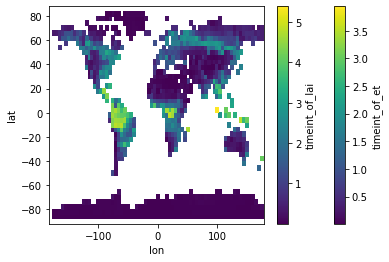

In [22]:
if doanalysis ==1: 
    ds=gppbm.timeint_of_gpp
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5.0)),
                    }
                   )
    regridder = xe.Regridder(ds, ds_out, 'bilinear')
    regridder.clean_weight_file()
    regridder
    ds_out_GPP_obs = regridder(ds)
    ds_out_GPP_obs = ds_out_GPP_obs.where(ds_out_GPP_obs<10000,0,0)
    ds_out_GPP_obs = ds_out_GPP_obs.where(ds_out_GPP_obs>0.0001,np.nan,0)


    ds=glbm.timeint_of_et
    regridder = xe.Regridder(ds, ds_out, 'bilinear')
    regridder.clean_weight_file()
    regridder
    ds_out_ET_obs = regridder(ds)
    ds_out_ET_obs = ds_out_ET_obs.where(ds_out_ET_obs<10000,0,0)
    ds_out_ET_obs = ds_out_ET_obs.where(ds_out_ET_obs>0.0001,np.nan,0)
    ds_out_ET_obs.plot()
    
    ds=laibm.timeint_of_lai
    regridder = xe.Regridder(ds, ds_out, 'bilinear')
    regridder.clean_weight_file()
    regridder
    ds_out_LAI_obs = regridder(ds)
    ds_out_LAI_obs = ds_out_LAI_obs.where(ds_out_LAI_obs<10000,0,0)
    ds_out_LAI_obs = ds_out_LAI_obs.where(ds_out_LAI_obs>0.0001,np.nan,0)
    ds_out_LAI_obs.plot()

    ds=efbm.timeint_of_EvapFrac
    regridder = xe.Regridder(ds, ds_out, 'bilinear')
    regridder.clean_weight_file()
    regridder
    ds_out_EF_obs = regridder(ds)
    ds_out_EF_obs = ds_out_EF_obs.where(ds_out_EF_obs<10000,0,0)



<h3>Make output figure directory</h3>

In [23]:
%%bash -s "$notebookdr"  
notebookdr=$2

cd $notebookdr
if [[ -d "figs" ]]
then
   echo "existing fig firectory"
else 
    mkdir figs
    echo "made fig firectory"
fi

existing fig firectory


In [24]:
ychoose=2004

<h3>Concatenate a year of values in each history directory</h3>

In [25]:
# Concatenature years in question using python. 

if doanalysis ==1:
    vs=range(0,ncases+1) 
    print(vs)
    count=1
    ncol=3
    print(caseroot)
    for i in vs:
        print(i)
        run=caseroot+str(i)
        arc = output + 'archive/' + run + '/lnd/hist/'
        f2= arc + '/'+str(ychoose)+'combined.nc'
        if(os.path.isdir(arc)):
            arc = arc
        else:
            arc = output + run + '/run/'
            print('output in run dir')
        fileout = arc + '/'+str(ychoose)+'combined.nc'
        #os.remove(fileout)
        print(fileout)
        if(os.path.isfile(fileout)):
            print('file exists')
            arc=arc
        else:
            ds0 = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
            ds0.to_netcdf(fileout)
            print(arc)

print('end')
                      

range(0, 126)
spfates_noc4_n8_
0
/glade/scratch/rfisher/archive/spfates_noc4_n8_0/lnd/hist//2004combined.nc
file exists
1
/glade/scratch/rfisher/archive/spfates_noc4_n8_1/lnd/hist//2004combined.nc
file exists
2
/glade/scratch/rfisher/archive/spfates_noc4_n8_2/lnd/hist//2004combined.nc
file exists
3
/glade/scratch/rfisher/archive/spfates_noc4_n8_3/lnd/hist//2004combined.nc
file exists
4
output in run dir
/glade/scratch/rfisher/spfates_noc4_n8_4/run//2004combined.nc
file exists
5
/glade/scratch/rfisher/archive/spfates_noc4_n8_5/lnd/hist//2004combined.nc
file exists
6
/glade/scratch/rfisher/archive/spfates_noc4_n8_6/lnd/hist//2004combined.nc
file exists
7
/glade/scratch/rfisher/archive/spfates_noc4_n8_7/lnd/hist//2004combined.nc
file exists
8
/glade/scratch/rfisher/archive/spfates_noc4_n8_8/lnd/hist//2004combined.nc
file exists
9
/glade/scratch/rfisher/archive/spfates_noc4_n8_9/lnd/hist//2004combined.nc
file exists
10
/glade/scratch/rfisher/archive/spfates_noc4_n8_10/lnd/hist//2004combine

<h3>Make a single data structure for the ensemble</h3>

In [26]:
# Concatenature years in question using python. 
if doanalysis ==1:
    vs=range(0,ncases+1) 
    #count=1
    run=caseroot+str(1)
    arc = output + 'archive/' + run + '/lnd/hist/'
    arc = output + run + '/run/'
    files=['li']*(ncases+1)
    print(files)
    ncol=3
    
    for i in vs:
        run=caseroot+str(i)
        arc = output + 'archive/' + run + '/lnd/hist/'
        f2=(arc +run+yr+str(ychoose)+'-01.nc') 
        if(os.path.isfile(f2)):
            arc=arc
        else:
            arc = output + run + '/run/'
        print(arc)
        fileout = arc + str(ychoose)+'combined.nc'
        print(fileout,i)
        files[i]=fileout
        
files=files[slice(0,ncases+1)]

dse1=xr.open_mfdataset(files, concat_dim='realization',decode_times=False)
print('end')

['li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li', 'li']
/glade/scratch/rfisher/archive/spfates_noc4_n8_0/lnd/hist/
/glade/scratch/rfisher/archive/spfates_noc4_n8_0/lnd/hist/2004combined.nc 0
/glade/scratch/rfisher/archive/spfates_noc4_n8_1/lnd/hist/
/glade/scratch/rfisher/archive/spfates_noc4_n8_1/

<h3> ET plot</h3>

1 1
1 1
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
calib
(5, 5, 5, 45, 72)
g d v 0 0 0
2 2
2 2
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
calib
(5, 5, 5, 45, 72)
g d v 0 0 1
3 3
3 3
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
calib
(5, 5, 5, 45, 72)
g d v 0 0 2
4 4
4 4
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
calib
(5, 5, 5, 45, 72)
g d v 0 0 3
5 5
5 5
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
calib
(5, 5, 5, 45, 72)
g d v 0 0 4
6 6
6 6
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
calib
(5, 5, 5, 45, 72)
g d v 0 1 0
7 7
7 7
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
calib
(5, 5, 5, 45, 72)
g d v 0 1 1
8 8
8 8
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
calib
(5, 5, 5, 45, 72)
g d v 0 1 2
9 9
9 9


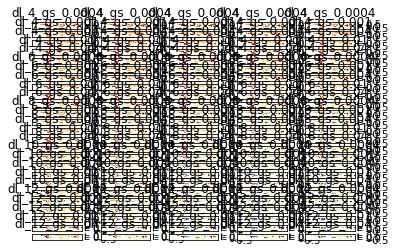

In [27]:
import time
delta=0
rel=0
if(dim3 == 0):
    ETrespsf=np.empty([5, 5,45,72])
else:
    ETrespsf=np.empty([5, 5, 5,45,72])
    
if doanalysis ==1:
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5)),})
    conv=24*3600
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [25,35]
    fig.subplots_adjust(hspace=0.4, wspace=0.1)    
    vs=[1, 2,3,4,5,6,7,8, 9,10,11,12]
    vs=range(1,ncases+1)
   # vs=range(1,15)
    count=1

    ncol=7
    nrow=2
    if(calib == 1):
        ncol=5
        nrow=25
    for i in vs:
        print(i, count)
        index=((count+1) % 2)*ncol + ((count+1) // 2)
        if( calib == 1 ):
            index=i
        print(i,index)
        ax = fig.add_subplot(nrow, ncol, index)
        count=count+1
        ds0  =dse1.isel(realization=i)
        dsdef=dse1.isel(realization=0)
        if(delta == 1):
            mod =np.multiply(np.mean(ds0.QFLX_EVAP_TOT,0),conv)
            deft=np.multiply(np.mean(dsdef.QFLX_EVAP_TOT,0),conv)
            
            if(rel==0):
                delt=mod-deft
                plt1=delt.plot(vmin=-0.4, vmax=0.4,cmap='RdYlBu')
                print('i',i)
            else: #relativised diffs 
                delt=(100*(mod-deft)/deft)+0.5
                print(i)
                plt1=delt.plot(vmin=-1, vmax=1,cmap='RdYlBu') 
        else:
             ds=np.multiply(np.mean(ds0.QFLX_EVAP_TOT,0),conv)
             regridder = xe.Regridder(ds, ds_out, 'bilinear')
             regridder.clean_weight_file()
             regridder
             ds_out_model = regridder(ds)
     
             ds_out_model = ds_out_model.where(ds_out_model>0.0001,np.nan,0)          
             if(rel==1):
                diff=100*(ds_out_model-ds_out_ET_obs)/ds_out_ET_obs
                plt1=diff.plot(vmin=-100, vmax=0,cmap='RdYlBu') 
             else:
                diff=(ds_out_model-ds_out_ET_obs)
                plt1=diff.plot(vmin=-0.75, vmax=0.75,cmap='RdYlBu') 
             e=diff.values 
            # ef=np.flip(e,0)
            # ef2=np.flip(ef,1)
             if(calib == 1):
                print('calib')
                print(np.shape(ETrespsf))
                if(dim3 == 0):
                    ETrespsf [gi[count-1], di[count-1],:,:]=e
                else:
                    print('g d v',gi[count-1], di[count-1],vi[count-1])
                    ETrespsf [gi[count-1], di[count-1],vi[count-1],:,:]=e               
            
      
             if( calib == 1):
                titl='dl_'+ str(gsarr[gi[count-1]])+'_gs_'+str(dlarr[di[count-1]])
                ax.set_title(titl)

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if( calib == 0):
            ax.set_title(titles[i-1]) 
        fig.canvas.draw()
       # time.sleep(1) 
        
if(delta == 1):
    if(rel==1):
        fnmfig='figs/ensemble_ET_delta_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_ET_delta_abs_'+caseroot +str(i)+'.png'       
else:
    if(rel==1):
        fnmfig='figs/ensemble_ET_error_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_ET_error_abs_'+caseroot +str(i)+'.png'       

print(fnmfig)
plt.savefig(fnmfig)


### C_STOMATA PLOT

1
2
3
4
5
6
7
8
9
10
11
12
13


KeyboardInterrupt: 

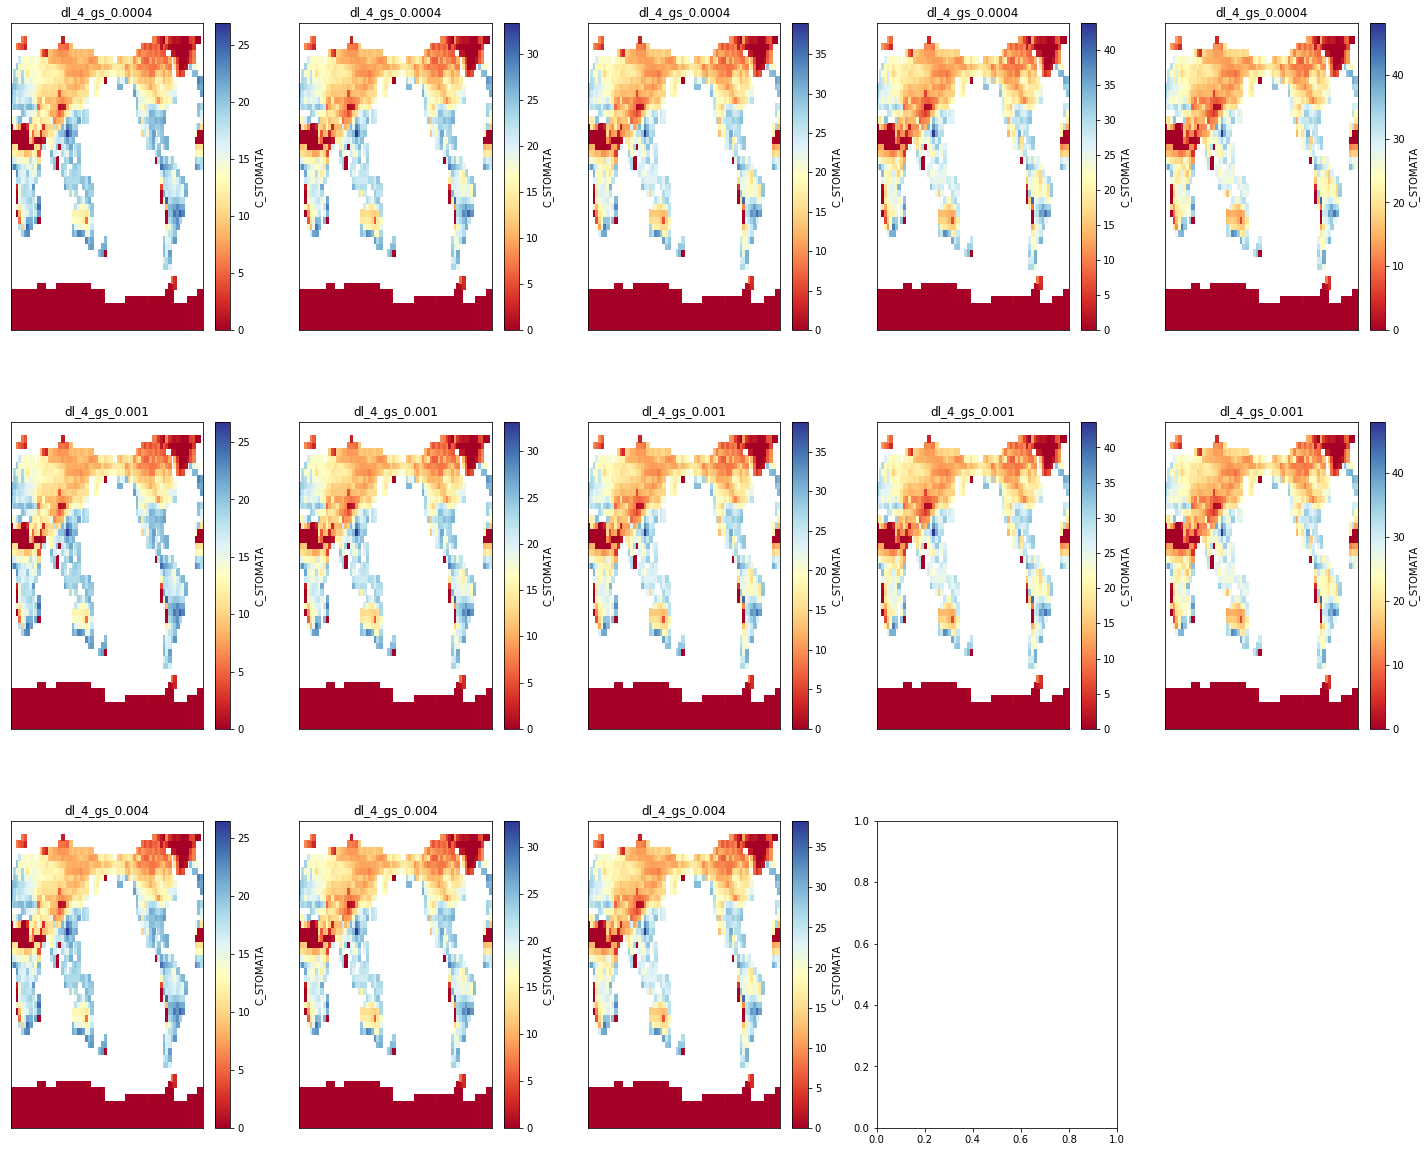

In [28]:
import time
delta=0
rel=0
conv=1e-3    
if doanalysis ==1:
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5)),})
    
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [15,7]
    fig.subplots_adjust(hspace=0.3, wspace=0.2)    
    vs=[1, 2,3,4,5,6,7,8, 9,10,11,12]
    vs=range(1,ncases+1)
   # vs=range(1,15)
    count=1

    ncol=7
    nrow=2
    if(calib == 1):
        ncol=5
        nrow=5
    for i in vs:
        index=((count+1) % 2)*ncol + ((count+1) // 2)
        if( calib == 1 ):
            index=i
        ax = fig.add_subplot(nrow, ncol, index)
        count=count+1
        ds0  =dse1.isel(realization=i)
        dsdef=dse1.isel(realization=0)
        print(i)
        mod =np.multiply(np.mean(ds0.C_STOMATA,0),conv)
        elai=np.mean(ds0.ELAI,0)
        #mod = mod * elai
        if(delta == 1):
            
            deft=np.multiply(np.mean(dsdef.C_STOMATA,0),conv)

            if(rel==0):
                delt=mod-deft
                plt1=delt.plot(vmin=-100, vmax=100,cmap='RdYlBu')
                print('i',i)
            else: #relativised diffs 
                delt=(100*(mod-deft)/deft)+0.5
                
                plt1=delt.plot(vmin=-1, vmax=1,cmap='RdYlBu') 

                # if( calib == 1):
       #     ax.set_title(str(i) )
        else:
            plt1=mod.plot(cmap='RdYlBu')
            titl='dl_'+ str(gsarr[gi[count-1]])+'_gs_'+str(dlarr[di[count-1]])
            ax.set_title(titl)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if( calib == 0):
            ax.set_title(titles[i-1]) 
        else:
            titl='dl_'+ str(gsarr[gi[count-1]])+'_gs_'+str(dlarr[di[count-1]])
            ax.set_title(titl)
        fig.canvas.draw()
        time.sleep(1) 
        
if(delta == 1):
    if(rel==1):
        fnmfig='figs/ensemble_GS_delta_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_GS_delta_abs_'+caseroot +str(i)+'.png'       

print(fnmfig)
plt.savefig(fnmfig)


### LBL_PLOT

In [ ]:
import time
delta=0
conv = 1e-3    
if doanalysis ==1:
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5)),})
    #conv=24*3600
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [15,7]
    fig.subplots_adjust(hspace=0.4, wspace=0.2)    
    vs=[1, 2,3,4,5,6,7,8, 9,10,11,12]
    vs=range(1,ncases+1)
   # vs=range(1,15)
    count=1

    ncol=7
    nrow=2
    if(calib == 1):
        ncol=5
        nrow=5
    for i in vs:
        index=((count+1) % 2)*ncol + ((count+1) // 2)
        if( calib == 1 ):
            index=i
        print(i,index)
        ax = fig.add_subplot(nrow, ncol, index)
        count=count+1
        ds0  =dse1.isel(realization=i)
        dsdef=dse1.isel(realization=0)
        mod =np.multiply(np.mean(ds0.C_LBLAYER,0),conv)
        if(delta == 1):

            deft=np.multiply(np.mean(dsdef.C_LBLAYER,0),conv)
            
            if(rel==0):
                delt=mod-deft
                plt1=delt.plot(cmap='RdYlBu')
                print('i',i)
            else: #relativised diffs 
                delt=(100*(mod-deft)/deft)+0.5
                print(i)
                plt1=delt.plot(vmin=-1, vmax=1,cmap='RdYlBu') 

                # if( calib == 1):
       #     ax.set_title(str(i) )
        else:
           plt1=mod.plot(cmap='RdYlBu',vmin=0, vmax=10000)
           titl='dl_'+ str(gsarr[gi[count-1]])+'_gs_'+str(dlarr[di[count-1]])
           ax.set_title(titl)
        ax.get_xaxis().set_visible(False)        
        ax.get_yaxis().set_visible(False)
        if( calib == 0):
            ax.set_title(titles[i-1]) 
        else:
            titl='dl_'+ str(gsarr[gi[count-1]])+'_gs_'+str(dlarr[di[count-1]])
            ax.set_title(titl)
 
        fig.canvas.draw()
        time.sleep(1) 
        
if(delta == 1):
    if(rel==1):
        fnmfig='figs/ensemble_LBL_delta_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_LBL_delta_abs_'+caseroot +str(i)+'.png'       

print(fnmfig)
plt.savefig(fnmfig)


### CONDUCTANCE DEFAULTS

In [ ]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [18,10]
fig.subplots_adjust(hspace=0.1, wspace=0.1)

conv = 1e-3

dsdef=dse1.isel(realization=6)
lbl=np.multiply(np.mean(dsdef.C_LBLAYER,0),conv)
gs=np.multiply(np.mean(dsdef.C_STOMATA,0),conv)
elai=np.mean(dsdef.ELAI,0)
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
'lon': (['lon'], np.arange(-180, 180, 5)),})
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder.clean_weight_file()
regridder
et_out_model = regridder(ds)

ax = fig.add_subplot(2, 2, 1)
plt1=lbl.plot(cmap='viridis')
ax.set_title('C_LBLAYER') 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(ymin=-60,ymax=83)

ax = fig.add_subplot(2, 2, 2)
cond_scaled = gs * elai
plt1=cond_scaled.plot(cmap='viridis')
ax.set_title('C_STOMATA') 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(ymin=-60,ymax=83)
print(di[3],dlarr)
fnmfig='figs/defualt_COND_'+caseroot+'.png'
print(fnmfig)
plt.savefig(fnmfig)

<h3> ET default model plot</h3>

In [ ]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [18,10]
fig.subplots_adjust(hspace=0.1, wspace=0.1)

conv=24*3600
dsdef=dse1.isel(realization=0)
ds=np.multiply(np.mean(dsdef.QFLX_EVAP_TOT,0),conv)
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
'lon': (['lon'], np.arange(-180, 180, 5)),})
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder.clean_weight_file()
regridder
et_out_model = regridder(ds)

ax = fig.add_subplot(2, 2, 1)
plt1=et_out_model.plot(vmin=0, vmax=4,cmap='viridis')
ax.set_title('ET Mod') 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(ymin=-60,ymax=83)

ax = fig.add_subplot(2, 2, 2)
plt1=ds_out_ET_obs.plot(vmin=0, vmax=4,cmap='viridis')
ax.set_title('ET Obs') 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(ymin=-60,ymax=83)

diffgpp=et_out_model-ds_out_ET_obs
ax = fig.add_subplot(2, 2, 3)
plt1=diffgpp.plot(vmin=0-0.5, vmax=0.5,cmap='bwr') 
ax.set_title('ET Bias') 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(ymin=-60,ymax=83)

fnmfig='figs/defualt_ET_modobs_'+caseroot+'.png'
print(fnmfig)
plt.savefig(fnmfig)

<h3> GPP default model plot</h3>

In [ ]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [18,10]
fig.subplots_adjust(hspace=0.1, wspace=0.1)

dsdef=dse1.isel(realization=0)
ds=np.multiply(np.mean(dsdef.GPP,0),conv)
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
'lon': (['lon'], np.arange(-180, 180, 5)),})
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder.clean_weight_file()
regridder
gpp_out_model = regridder(ds)

ax = fig.add_subplot(2, 2, 1)
plt1=gpp_out_model.plot(vmin=0, vmax=9,cmap='viridis')
ax.set_title('GPP Mod') 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(ymin=-60,ymax=83)

ax = fig.add_subplot(2, 2, 2)
plt1=ds_out_GPP_obs.plot(vmin=0, vmax=9,cmap='viridis')
ax.set_title('GPP Obs') 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(ymin=-60,ymax=83)

diffgpp=gpp_out_model-ds_out_GPP_obs
ax = fig.add_subplot(2, 2, 3)
plt1=diffgpp.plot(vmin=-2, vmax=2,cmap='bwr') 
ax.set_title('GPP Bias') 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(ymin=-60,ymax=83)

fnmfig='figs/defualt_GPP_modobs_'+caseroot+'.png'
print(fnmfig)
plt.savefig(fnmfig)

<h3> LAI default model plot</h3>

In [ ]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [18,10]
fig.subplots_adjust(hspace=0.1, wspace=0.1)

dsdef=dse1.isel(realization=0)
ds=np.multiply(np.mean(dsdef.ELAI,0),1)
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
'lon': (['lon'], np.arange(-180, 180, 5)),})
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder.clean_weight_file()
regridder
lai_out_model = regridder(ds)

ax = fig.add_subplot(2, 2, 1)
plt1=lai_out_model.plot(vmin=0, vmax=7,cmap='viridis')
ax.set_title('LAI Mod') 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(ymin=-60,ymax=83)

ax = fig.add_subplot(2, 2, 2)
plt1=ds_out_LAI_obs.plot(vmin=0, vmax=7,cmap='viridis')
ax.set_title('LAI Obs') 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(ymin=-60,ymax=83)

diffgpp=lai_out_model-ds_out_LAI_obs
ax = fig.add_subplot(2, 2, 3)
plt1=diffgpp.plot(vmin=0-1, vmax=1,cmap='bwr') 
ax.set_title('LAI Bias') 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(ymin=-60,ymax=83)

fnmfig='figs/defualt_LAI_modobs_'+caseroot+'.png'
print(fnmfig)
plt.savefig(fnmfig)

<h3> GPP plot</h3>

In [ ]:
import time
delta=0
rel=0
GPPrespsf=np.empty([5, 5,45,72])

if doanalysis ==1:
    conv=24*3600
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [15,7]
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    vs=[1, 2,3,4,5,6,7,8, 9,10,11,12]  
    vs=range(1,ncases+1)
    ncol=7
    nrow=2
    if(calib == 1):
        ncol=5
        nrow=5
 #vs=range(7,19)
    print(vs)
    count=1
    for i in vs:
        index=((count+1) % 2)*ncol + ((count+1) // 2)
        if( calib == 1 ):
            index=i
        print(i)
        ax = fig.add_subplot(nrow, ncol, index)
        count=count+1
        ds0=dse1.isel(realization=i)
        dsdef=dse1.isel(realization=0)
        if(delta == 1):
            mod=np.multiply(np.mean(ds0.GPP,0),conv)
            deft=np.multiply(np.mean(dsdef.GPP,0),conv)
            if(rel==0):
                delt=mod-deft
                plt1=delt.plot(vmin=-0.5, vmax=0.5,cmap='RdYlBu')
            else: #relativised diffs 
                delt=100*(mod-deft)/deft
                plt1=delt.plot(vmin=-1, vmax=1,cmap='RdYlBu') 
        else:
             ds=np.multiply(np.mean(ds0.GPP,0),conv)
             ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5)),})
             regridder = xe.Regridder(ds, ds_out, 'bilinear')
             regridder.clean_weight_file()
             regridder
             ds_out_model = regridder(ds)
             diff=ds_out_model-ds_out_GPP_obs
             plt1=diff.plot(vmin=-2, vmax=2,cmap='RdYlBu') 
             if(calib == 1):
                    GPPrespsf[gi[count-1],di[count-1],:,:]=diff.values       

        #plt1=ds_out_model.plot(vmin=0, vmax=12,cmap='bwr') 
        #if( calib == 0):
        #    ax.set_title(titles[i-1]) 
       #     ax.set_title(str(i) )
       # else:
             if( calib == 1):
                titl='dl_'+ str(gsarr[gi[count-1]])+'_gs_'+str(dlarr[di[count-1]])
                ax.set_title(titl)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        fig.canvas.draw()
        time.sleep(1) 
        
if(delta == 1):
    if(rel==1):
        fnmfig='figs/ensemble_GPP_delta_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_GPP_delta_abs_'+caseroot +str(i)+'.png'       
else:
    if(rel==1):
        fnmfig='figs/ensemble_GPP_error_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_GPP_error_abs_'+caseroot +str(i)+'.png'       

print(fnmfig)
plt.savefig(fnmfig)

### WUE of model vs data

Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72

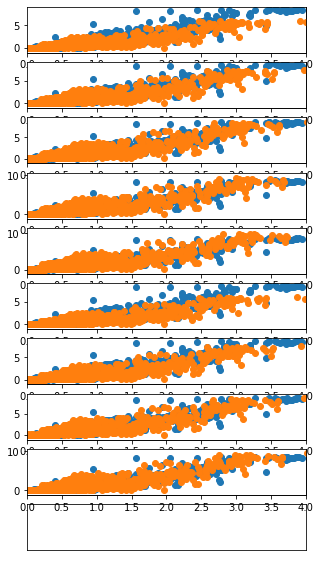

In [163]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(5, 10),
                        subplot_kw={'xticks': [], 'yticks': []})    


gg=range(1,10)
for g in gg:
    ds0=dse1.isel(realization=g)
    ds=np.multiply(np.mean(ds0.GPP,0),conv)
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5)),})
    regridder = xe.Regridder(ds, ds_out, 'bilinear')
    regridder.clean_weight_file()
    regridder
    gpp_out_model = regridder(ds)

    ds=np.multiply(np.mean(ds0.QFLX_EVAP_TOT,0),conv)
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5)),})
    regridder = xe.Regridder(ds, ds_out, 'bilinear')
    regridder.clean_weight_file()
    regridder
    et_out_model = regridder(ds)
    ax = fig.add_subplot(10, 1, g)
    plt.scatter(ds_out_ET_obs,ds_out_GPP_obs)
    plt.scatter(et_out_model,gpp_out_model) 
    plt.xlim(0,4)

<h3> LAI Plot<.h3>

In [ ]:
import time
if(sp == 0):
    delta=0
    rel=0
    if doanalysis ==1:
        conv=1
        fig = plt.figure()
        plt.rcParams['figure.figsize'] = [15,7]
        fig.subplots_adjust(hspace=0.1, wspace=0.1)
        vs=[1, 2, 5,6, 7, 8]
    
        vs=range(1,ncases+1)
        print(vs)
        count=1
        ncol=7
        for i in vs:
            index=((count+1) % 2)*ncol + ((count+1) // 2)
            ax = fig.add_subplot(2, ncol, index)
            count=count+1
            ds0=dse1.isel(realization=i)
            if(delta == 1):
                mod=np.multiply(np.mean(ds0.ELAI,0),conv)
                deft=np.multiply(np.mean(dsdef.ELAI,0),conv)
                if(rel==0):
                    delt=mod-deft
                    plt1=delt.plot(vmin=-1, vmax=1,cmap='RdYlBu')
                else: #relativised diffs 
                    delt=100*(mod-deft)/deft
                    plt1=delt.plot(vmin=-5, vmax=5,cmap='RdYlBu') 
            else:
                 ds=np.multiply(np.mean(ds0.ELAI,0),conv)
                 ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5)),})
                 regridder = xe.Regridder(ds, ds_out_model, 'bilinear')
                 regridder.clean_weight_file()
                 regridder
                 ds_out_model = regridder(ds)
                 diff=ds_out_model-ds_out_GPP_obs
                 plt1=diff.plot(vmin=-6, vmax=6,cmap='RdYlBu') 

            #plt1=ds_out_model.plot(vmin=0, vmax=12,cmap='bwr') 
            if( calib == 1):
                ax.set_title(str(i) )
            else:
                ax.set_title(titles[i-1]) 
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
            fig.canvas.draw()
            time.sleep(1) 
        
    if(delta == 1):
        if(rel==1):
            fnmfig='figs/ensemble_TLAI_delta_rel_'+caseroot +str(i)+'.png'
        else:
            fnmfig='figs/ensemble_TLAI_delta_abs_'+caseroot +str(i)+'.png'       
    else:
        if(rel==1):
            fnmfig='figs/ensemble_TLAI_error_rel_'+caseroot +str(i)+'.png'
        else:
            fnmfig='figs/ensemble_TLAI_error_abs_'+caseroot +str(i)+'.png'       

    print(fnmfig)
    plt.savefig(fnmfig)

<h3> Plot of the 2D error structure at a single point</h3>

In [ ]:
if(calib == 1 and dim3 == 0):
    
    lcount=0
    tcount=0
    lrng=range(20,29)
    trng=range(10,27)
    l=lrng[3]
    t=trng[10]
    lonst=ds0.lon.values[1]
        
    lcount = lcount+1
    latst=ds0.lat.values[1]
    rr=ETrespsf[:,:,t,l]
    rr=np.square(rr)
    img1=plt.imshow(rr, cmap='viridis')

    plt.colorbar()
    
   
    fnmfig='figs/singlepnt_2Derror_GPP.png'       
    print(fnmfig)
    plt.savefig(fnmfig)
    

<h3> Plot of the 3D error structure at a single point</h3>

5
20
0 20 25
1 20 25
2 20 25
3 20 25
4 20 25
figs/singlepnt_error_GPP.png


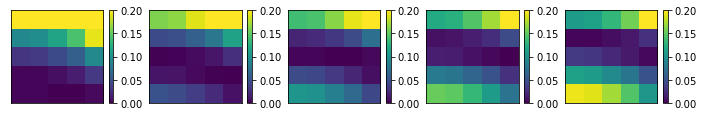

In [55]:
if(calib == 1 and dim3 == 1):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 1.7),
                        subplot_kw={'xticks': [], 'yticks': []})    
    lcount=0
    tcount=0
    lrng=range(20,29)
    trng=range(10,27)
    l=lrng[5]
    t=trng[10]
    lonst=ds0.lon.values[1]        
    lcount = lcount+1
    latst=ds0.lat.values[1]

    vv=range(0,5)
    print(np.size(ETrespsf,0))
    print(t)
          
    for v in vv:
        count=count+1
        print(v,t,l)
        rr=ETrespsf[:,:,v,t,l]
        rr=np.square(rr)
        img1=axs[v].imshow(rr, cmap='viridis',vmax=0.2,vmin=0)
        fig.colorbar(img1, ax=axs[v])    
    fnmfig='figs/singlepnt_error_GPP.png'       
    print(fnmfig)
    plt.savefig(fnmfig)
    

In [ ]:
if(calib == 1):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    fig = plt.figure()
   # ax = fig.add_subplot(111, projection='3d')
    lcount=0
    tcount=0
    lrng=range(20,29)
    trng=range(10,27)
    l=lrng[3]
    t=trng[10]
    lonst=ds0.lon.values[1]
        
    lcount = lcount+1
    latst=ds0.lat.values[1]
    zz=GPPrespsf[:,:,t,l]
    zz=np.square(zz)
    xx, yy = np.meshgrid(np.linspace(0,1,5), np.linspace(0,1,5))
    ax2 = fig.add_subplot( projection='3d')
    print(zz)
    cset = ax2.contourf(xx, yy, zz, 100, zdir='z',  cmap=cm.BrBG)
    #Axes3D.plot_surface(xx,yy,zz)


    fnmfig='figs/singlepnt_error_GPP.png'       
    print(fnmfig)
    plt.savefig(fnmfig)

<h3>GPP error structures</h3>

In [ ]:

if(calib == 1):
    nr=17
    nc=9
    import numpy as np
    fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(12, 25),
                        subplot_kw={'xticks': [], 'yticks': []})
    lcount=0
    tcount=0
    lrng=range(20,29)
    trng=range(10,27)
    for l in lrng:
        lonst=ds0.lon.values[l]
        lcount = lcount+1
        tcount=0
        axs[1,1].axis('off')
        for t in trng:
            latst=diff.lat.values[t]
            tcount=tcount+1
            axs[nr-(tcount)-1,lcount-1].axis('off')
            rr=GPPrespsf[:,:,t,l] 
            rr=np.square(rr)
            img1=axs[nr-(tcount)-1,lcount-1].imshow(rr, cmap='viridis')
    plt.tight_layout()
    fnmfig='figs/SouthAmer_error_GPP.png'       
    print(fnmfig)
    plt.savefig(fnmfig)
    
    plt.show()

<h3>ET error structures</h3>

figs/SouthAmer_error_ET.png


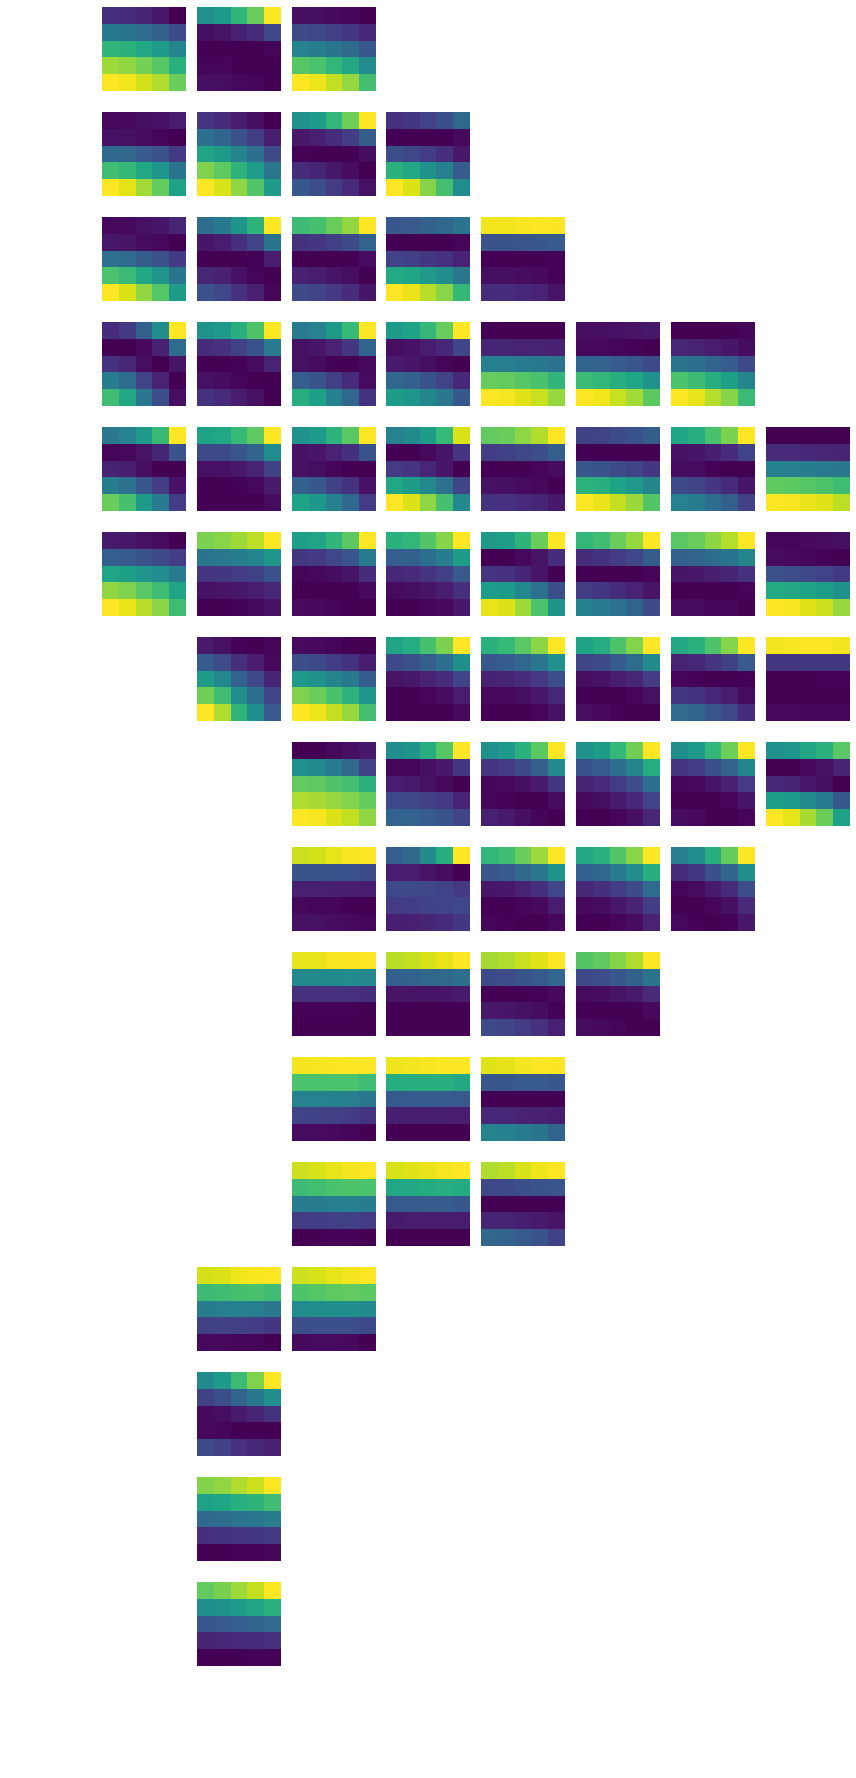

In [36]:
conv=24*3600
if(calib == 1):
    nr=17
    nc=9
    import numpy as np
    fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(12, 25),
                        subplot_kw={'xticks': [], 'yticks': []})
    lcount=0
    tcount=0
    lrng=range(20,29)
    trng=range(10,27)
    for l in lrng:
        lonst=ds0.lon.values[l]
        lcount = lcount+1
        tcount=0
        axs[1,1].axis('off')
        for t in trng:
            latst=diff.lat.values[t]
            tcount=tcount+1
            axs[nr-(tcount)-1,lcount-1].axis('off')
            rr=ETrespsf[:,:,4,t,l] 
            rr=np.square(rr)
            img1=axs[nr-(tcount)-1,lcount-1].imshow(rr, cmap='viridis')
    plt.tight_layout()
    fnmfig='figs/SouthAmer_error_ET.png'       
    print(fnmfig)
    plt.savefig(fnmfig)
    
    plt.show()

<h3>weighted error structures</h3>

In [ ]:
if(calib == 1):
    nr=17
    nc=9
    import numpy as np
    fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(12, 25),
                        subplot_kw={'xticks': [], 'yticks': []})
    lcount=0
    tcount=0
    lrng=range(20,29)
    trng=range(10,27)
    for l in lrng:
        lonst=diff.lon.values[l]
        lcount = lcount+1
        tcount=0
        axs[1,1].axis('off')
        for t in trng:
            latst=diff.lat.values[t]
            tcount=tcount+1
            axs[nr-(tcount)-1,lcount-1].axis('off')
            rr=ETrespsf[:,:,t,l] +GPPrespsf[:,:,t,l]*0.5
            rr=np.square(rr)
            img1=axs[nr-(tcount)-1,lcount-1].imshow(rr, cmap='viridis')
    plt.tight_layout()
    fnmfig='figs/SouthAmer_error_comb.png'       
    print(fnmfig)
    plt.savefig(fnmfig)
    
    plt.show()

### Regrid model output variables of interest

<h3> Make PFT specific 2D error structures<


Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
Create weight file: bilinear_46x72_45x72.nc
Remove file bilinear_46x72_45x72.nc
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunks

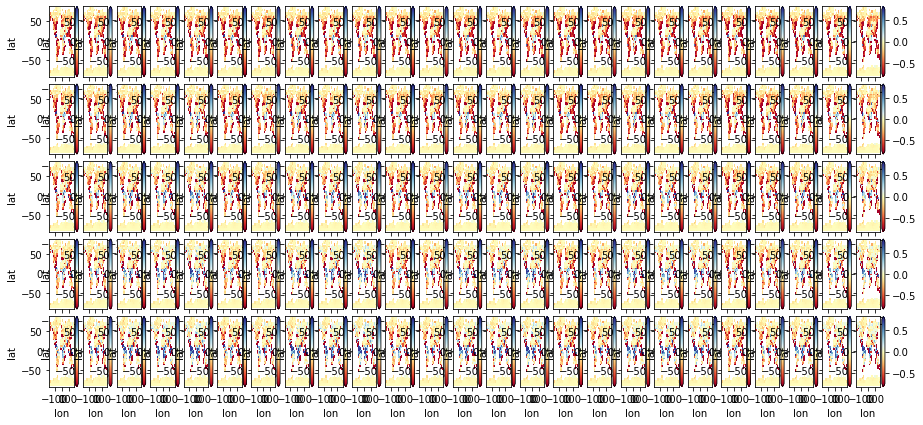

In [98]:
npft=12
import time
fig = plt.figure()
plt.rcParams['figure.figsize'] = [15,7]
fig.subplots_adjust(hspace=0.1, wspace=0.1)
conv=24*60*60

if( calib == 1 ):
    if doanalysis ==1:
        ETrespsf_pft=np.empty([5, 5,13]) 
        GPPrespsf_pft=np.empty([5, 5,13])
        if(dim3==1):
            ETrespsf_pft=np.empty([5, 5,5,13])
            GPPrespsf_pft=np.empty([5, 5,5,13])
        else:
            ETrespsf_pft=np.empty([5, 5,13]) 
            GPPrespsf_pft=np.empty([5, 5,13])            
        ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5)),})

        vs=range(1,ncases+1)
        count=1
        ds0=dse1.isel(realization=vs[1])
        dspftmap=np.multiply(np.mean(ds0.PFTleafbiomass,0),1) 
        regridder = xe.Regridder(dspftmap, ds_out, 'bilinear')
        regridder.clean_weight_file()
        regridder
        rg_pftmap = regridder(dspftmap)
        pfts=range(1,npft)
        ds0=dse1.isel(realization=0)
        dsdefg=np.multiply(np.mean(ds0.QFLX_EVAP_TOT,0),conv)
        #vs=range(1,2)
        for i in vs:
            ds0=dse1.isel(realization=i)        
            count=count+1    
            if(dim3==1):
                ax = fig.add_subplot(5, 25, i) 
            else:
                ax = fig.add_subplot(5, 5, i)       
            ds=np.multiply(np.mean(ds0.GPP,0),conv)
            regridder = xe.Regridder(ds, ds_out, 'bilinear');
            regridder.clean_weight_file();
            regridder;
            ds_out_modelGPP = regridder(ds);
            
            ds=np.multiply(np.mean(ds0.QFLX_EVAP_TOT,0),conv)
            regridder = xe.Regridder(ds, ds_out, 'bilinear');
            regridder.clean_weight_file();
            regridder; 
            ds_out_modelET = regridder(ds);
            relg=ds-dsdefg
            ds_out_modelET = ds_out_modelET.where(ds_out_modelET>0.000001,0,0) 
            ds_out_modelGPP = ds_out_modelGPP.where(ds_out_modelGPP>0.000001,0,0) 

            diffET = (ds_out_modelET-ds_out_ET_obs)
            diffGPP = (ds_out_modelGPP-ds_out_GPP_obs)
            
            diffET.plot(vmin=-0.75, vmax=0.75,cmap='RdYlBu')
            print(np.max(diffET))
            #diffET = np.sqrt(np.square(diffET))
            #diffGPP =np.sqrt(np.square(diffGPP))
            
            for p in pfts:                        
                pfta=rg_pftmap.isel(fates_levpft=p-1)/np.sum(rg_pftmap,0)                          
                ds_out_modelp = diffET.where(pfta>0.01,0,0);              
                e=ds_out_modelp.values
                e=np.where(np.isnan(e), 0, e)
                e=np.where(e>50, 0, e)
                e=np.square(e) 
                esumE=np.mean(np.mean(e,0),0)
                esumE=np.sqrt(esumE)

            
                ds_out_modelp = diffGPP.where(pfta>0.01,0,0);              
                e=ds_out_modelp.values
                e=np.where(np.isnan(e), 0, e)
                e=np.where(e>50, 0, e)
                e=np.square(e) 
                esumG=np.mean(np.mean(e,0),0)
                esumE=np.sqrt(esumE)
                #print(gi[count-1], di[count-1],p-1,esum)
                if(dim3==1):
                    ETrespsf_pft  [gi[count-1], di[count-1],vi[count-1],p-1]=esumE
                    GPPrespsf_pft [gi[count-1], di[count-1],vi[count-1],p-1]=esumG
                else:
                    ETrespsf_pft  [gi[count-1], di[count-1],p-1]=esumE
                    GPPrespsf_pft [gi[count-1], di[count-1],p-1]=esumG

                

### PFT map

figs/pft_cover.png


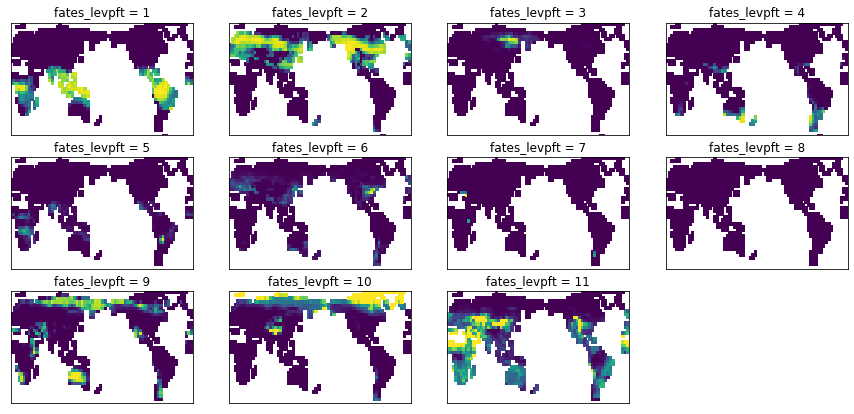

In [40]:
fig = plt.figure()
#plt.rcParams['figure.figsize'] = [15,7]
#fig.subplots_adjust(hspace=0.1, wspace=0.1)

#fig, axes = plt.subplots(nrows=4, ncols=4)

lb=np.mean(ds0.PFTleafbiomass,0)

for p in pfts:
   ax = fig.add_subplot(3, 4, p)
   pfta=lb.isel(fates_levpft=p-1)/np.sum(lb,0)

   pfta.plot(add_colorbar=False)    
   ax.set_ylim(ymin=-60,ymax=83)
   ax.get_xaxis().set_visible(False)
   ax.get_yaxis().set_visible(False)
fnmfig='figs/pft_cover.png'       
print(fnmfig)
plt.savefig(fnmfig)


### Plot PFT error structure

In [123]:

pftname_short=['BET','NET','NDT','BETT','BDDT','BCDT','BES','BDDS','BCDS','C3AG','C3G']

['BlEvTrTr', 'NlEvTr', 'NlCdDecTt', 'BlEvTmTr', 'BlDrDecTt', 'BlCdDecTr', 'BlEvSh', 'BlDrDecSh', 'BlCdDecSh', 'C3AG', 'C3G']


0.6390505317979234
0.5446348783219666
0.2547170398724732
0.3334605533365445
0.4211287786209176
0.4646599672556927
0.09002774915610186
0.0
0.3394730353224262
0.3516610208167554
0.7439597861745422
figs/fit2d_ETspfates_noc4_n8_125.png


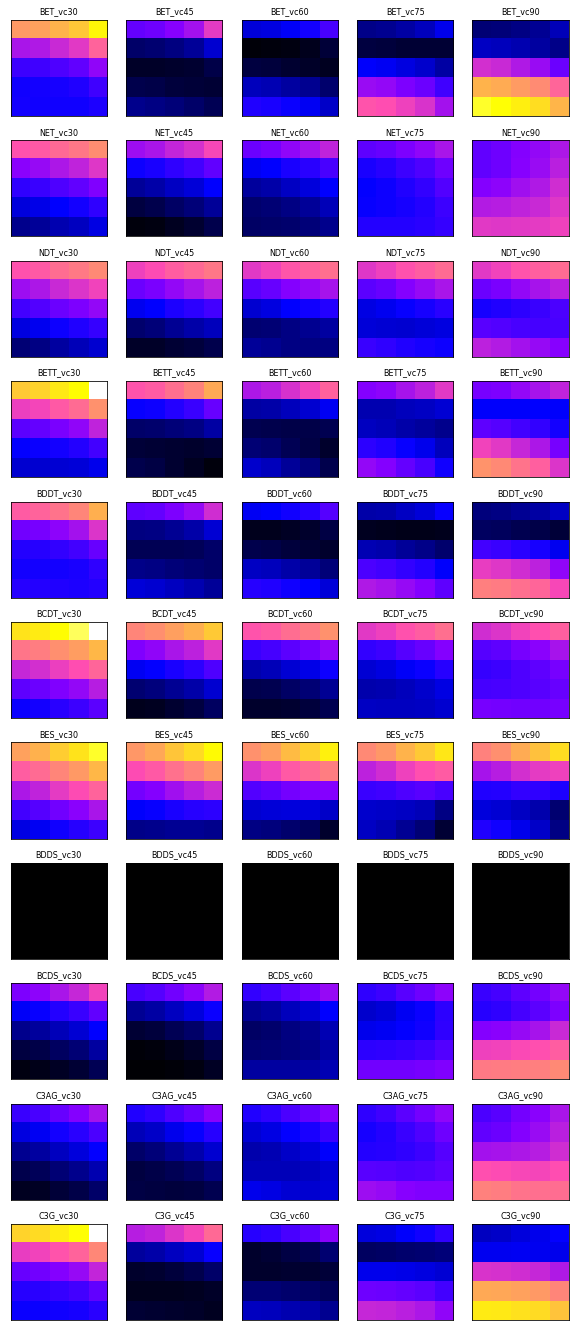

In [132]:

if(dim3==1):
    nr=npft-1
    nc=5
else: 
    nr=3
    nc=4
vv=range(0,5)    
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(10, 24),
                        subplot_kw={'xticks': [], 'yticks': []})
#fig.subplots_adjust(hspace=0.4, wspace=0)
for pft in pfts:
    if(dim3==0):
        rr=ETrespsf_pft[:,:,pft-1]+GPPrespsf_pft[:,:,pft-1]    
        row=((pft-1) % nc)
        col=(pft-1) // nc
        img1=axs[col,row].imshow(rr, cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        axs[col,row].set_title('pft='+pftnames[pft-1])
        ax.set_title(str(pft)) 
        plt.tight_layout()
    else:  #3D plots
        mxp=np.max(ETrespsf_pft[:,:,:,pft-1])+np.max(GPPrespsf_pft[:,:,:,pft-1])
        mnp=np.min(ETrespsf_pft[:,:,:,pft-1])+np.min(GPPrespsf_pft[:,:,:,pft-1])
        #print(ETrespsf_pft[:,:,:,pft-1])
        print(mxp)
        for v in vv:
            count=count+1
            rr=ETrespsf_pft[:,:,v,pft-1]+GPPrespsf_pft[:,:,v,pft-1] 
            img1=axs[pft-1,v].imshow(rr, cmap='gnuplot2',vmin=mnp,vmax=mxp)
            #fig.colorbar(img1, ax=axs[pft-1,v])  
            axs[pft-1,v].set_title(pftname_short[pft-1]+'_vc'+str(vcarr[v]),fontsize=8)
            pftname_short
#plt.tight_layout()
   
if(dim3==1):    
    fnmfig='figs/fit2d_ET'+caseroot +str(i)+'.png' 
else:
     fnmfig='figs/fit3d_ET'+caseroot +str(i)+'.png'    
print(fnmfig)
plt.savefig(fnmfig)


### collapse down onto single dleaf value 

1
3 4 0 0
2
3 4 1 0
3
3 4 2 0
4
3 4 3 0
5
3 4 0 1
6
3 4 1 1
7
3 4 2 1
8
3 4 3 1
9
3 4 0 2
10
3 4 1 2
11
3 4 2 2
figs/fit2d_ETspfates_noc4_n8_125.png


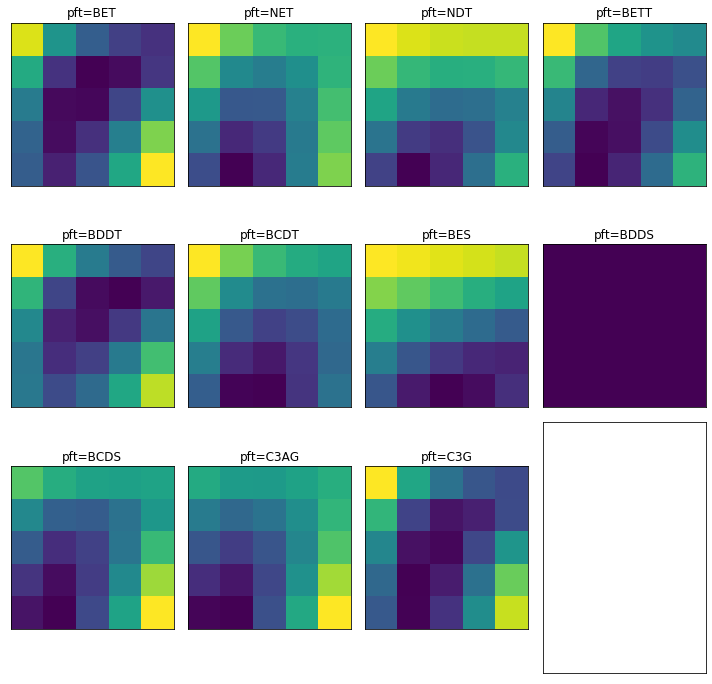

In [146]:
dl1=1

if(dim3==1):
    nr=npft-1
    nc=5
    figh=24
if(dim3==0 or dl1==1):
     nr=3
     nc=4 
     figh=10

vv=range(0,5)    
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(10, figh),
                        subplot_kw={'xticks': [], 'yticks': []})
#fig.subplots_adjust(hspace=0.4, wspace=0)
for pft in pfts:

    if(dim3==0 or dl1==1):
        if(dl1==0):
            rr=ETrespsf_pft[:,:,pft-1]+GPPrespsf_pft[:,:,pft-1]
        else:
            print(pft)
            rr=ETrespsf_pft[:,3,:,pft-1]+GPPrespsf_pft[:,3,:,pft-1]
        row=((pft-1) % nc)
        col=(pft-1) // nc
        print(nr,nc,row,col)
        img1=axs[col,row].imshow(rr, cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        axs[col,row].set_title('pft='+pftname_short[pft-1])
        ax.set_title(str(pft)) 
        plt.tight_layout()
    else:  #3D plots
        mxp=np.max(ETrespsf_pft[:,:,:,pft-1])+np.max(GPPrespsf_pft[:,:,:,pft-1])
        mnp=np.min(ETrespsf_pft[:,:,:,pft-1])+np.min(GPPrespsf_pft[:,:,:,pft-1])
        print(mxp)
        for v in vv:
            count=count+1
            rr=ETrespsf_pft[:,:,v,pft-1]+GPPrespsf_pft[:,:,v,pft-1] 
            img1=axs[pft-1,v].imshow(rr, cmap='gnuplot2',vmin=mnp,vmax=mxp)
            #fig.colorbar(img1, ax=axs[pft-1,v])  
            axs[pft-1,v].set_title(pftname_short[pft-1]+'_vc'+str(vcarr[v]),fontsize=8)
            pftname_short
#plt.tight_layout()
   
if(dim3==1):    
    fnmfig='figs/fit2d_ET'+caseroot +str(i)+'.png' 
else:
     fnmfig='figs/fit3d_ET'+caseroot +str(i)+'.png'    
print(fnmfig)
plt.savefig(fnmfig)


### Fit for GPP

figs/fit2d_GPPspfates_noc4_n8_125.png


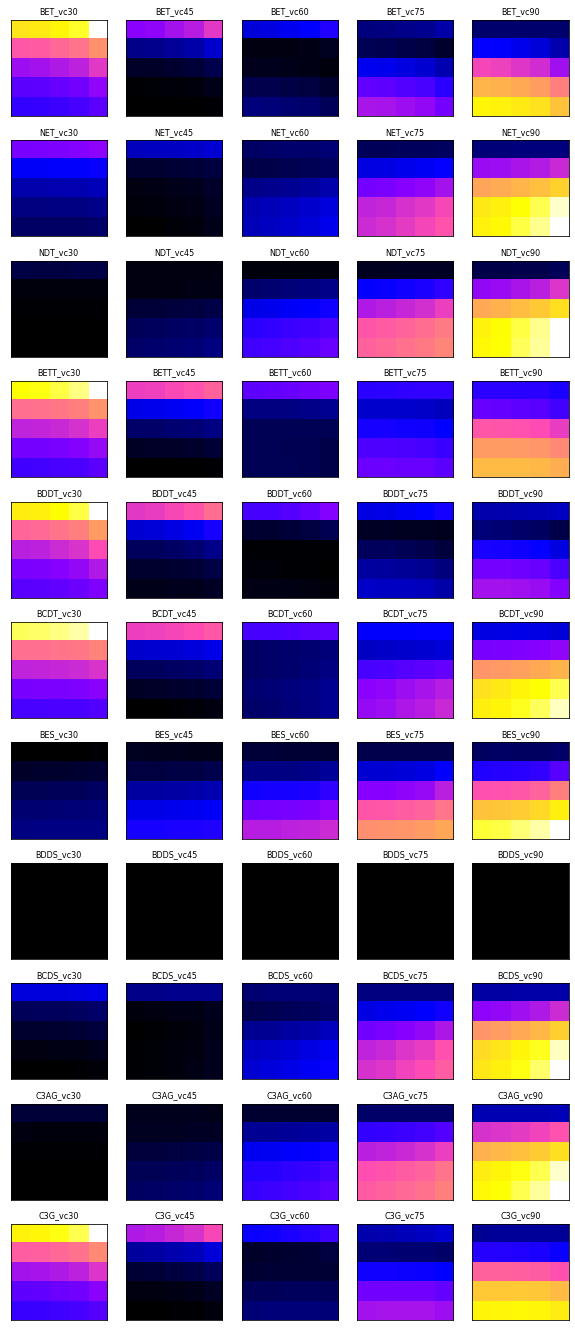

In [133]:

if(dim3==1):
    nr=npft-1
    nc=5
else: 
    nr=3
    nc=4
vv=range(0,5)    
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(10, 24),
                        subplot_kw={'xticks': [], 'yticks': []})
#fig.subplots_adjust(hspace=0.4, wspace=0)
for pft in pfts:
    if(dim3==0):
        rr=GPPrespsf_pft[:,:,pft-1]    
        row=((pft-1) % nc)
        col=(pft-1) // nc
        img1=axs[col,row].imshow(rr, cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        axs[col,row].set_title('pft='+pftnames[pft-1])
        ax.set_title(str(pft)) 
        plt.tight_layout()
    else:  #3D plots
        mxp=np.max(np.max(GPPrespsf_pft[:,:,:,pft-1]))
        mnp=np.min(np.min(GPPrespsf_pft[:,:,:,pft-1]))
        for v in vv:
            count=count+1
            rr=GPPrespsf_pft[:,:,v,pft-1] 
            img1=axs[pft-1,v].imshow(rr, cmap='gnuplot2',vmin=mnp,vmax=mxp)
            #fig.colorbar(img1, ax=axs[pft-1,v])  
            axs[pft-1,v].set_title(pftname_short[pft-1]+'_vc'+str(vcarr[v]),fontsize=8)
            pftname_short
#plt.tight_layout()
   
if(dim3==1):    
    fnmfig='figs/fit2d_GPP'+caseroot +str(i)+'.png' 
else:
     fnmfig='figs/fit3d_GPP'+caseroot +str(i)+'.png'    
print(fnmfig)
plt.savefig(fnmfig)


### Fit for ET

figs/fit2d_ETspfates_noc4_n8_125.png


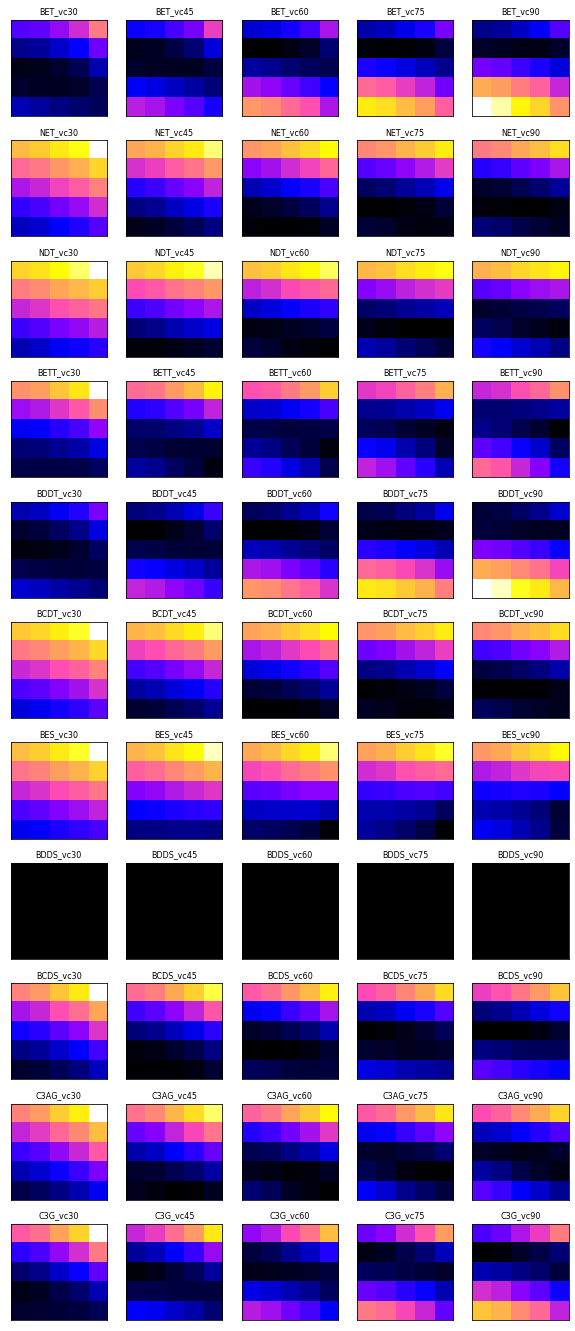

In [135]:

if(dim3==1):
    nr=npft-1
    nc=5
else: 
    nr=3
    nc=4
vv=range(0,5)    
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(10, 24),
                        subplot_kw={'xticks': [], 'yticks': []})
#fig.subplots_adjust(hspace=0.4, wspace=0)
for pft in pfts:
    if(dim3==0):
        rr=GPPrespsf_pft[:,:,pft-1]    
        row=((pft-1) % nc)
        col=(pft-1) // nc
        img1=axs[col,row].imshow(rr, cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        axs[col,row].set_title('pft='+pftnames[pft-1])
        ax.set_title(str(pft)) 
        plt.tight_layout()
    else:  #3D plots
        mxp=np.max(np.max(ETrespsf_pft[:,:,:,pft-1]))
        mnp=np.min(np.min(ETrespsf_pft[:,:,:,pft-1]))
        for v in vv:
            count=count+1
            rr=ETrespsf_pft[:,:,v,pft-1] 
            img1=axs[pft-1,v].imshow(rr, cmap='gnuplot2',vmin=mnp,vmax=mxp)
            #fig.colorbar(img1, ax=axs[pft-1,v])  
            axs[pft-1,v].set_title(pftname_short[pft-1]+'_vc'+str(vcarr[v]),fontsize=8)
            pftname_short
#plt.tight_layout()
   
if(dim3==1):    
    fnmfig='figs/fit2d_ET'+caseroot +str(i)+'.png' 
else:
     fnmfig='figs/fit3d_ET'+caseroot +str(i)+'.png'    
print(fnmfig)
plt.savefig(fnmfig)


In [ ]:
nr=3
nc=4
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(8, 5.6),
                        subplot_kw={'xticks': [], 'yticks': []})
for pft in pfts:
    rr=GPPrespsf_pft[:,:,pft-1]
    plt.imshow(rr, cmap='viridis')
    row=((pft-1) % nc)
    col=(pft-1) // nc
    img1=axs[col,row].imshow(rr, cmap='viridis')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    axs[col,row].set_title('pft='+pftnames[pft-1])
    ax.set_title(str(pft)) 
    plt.tight_layout()

fnmfig='figs/fit2d_GPP'+caseroot +str(i)+'.png'       
print(fnmfig)
plt.savefig(fnmfig)

<h3> So the parameterS are:</h3>


In [ ]:
nr=3
nc=4
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(8, 5.6),
                        subplot_kw={'xticks': [], 'yticks': []})
pfts=range(1,npft)
gsopt=np.empty([13])
vcopt=np.empty([13])

for pft in pfts:
#    ax = fig.add_subplot(4, 3, pft)
    rr=GPPrespsf_pft[:,:,pft-1]*0.5+ETrespsf_pft[:,:,pft-1]
    plt.imshow(rr, cmap='viridis')
    row=((pft-1) % nc)
    col=(pft-1) // nc
    img1=axs[col,row].imshow(rr, cmap='viridis')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    axs[col,row].set_title('PFT='+str(pft))
    ax.set_title(str(pft)) 
    plt.tight_layout()

    min=np.min(rr,axis=0)
    minv=np.argmin(min)
    vcopt[pft]=vcarr[minv]

    min=np.min(rr,axis=1)
    minv=np.argmin(min)
    gsopt[pft]=gsarr[minv]
    #'P'+str(pft)+',vc',+str(vcopt[pft])+',gf'
    axs[col,row].set_title('pft='+pftnames[pft-1])
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img1, cax=cbar_ax)

fnmfig='figs/fit2d_comb'+caseroot +str(i)+'.png'       
print(fnmfig)
plt.savefig(fnmfig)
print(gsopt)
print(vcopt)

In [ ]:
print(rr)
min=np.min(rr,axis=0)
print(min)
minv=np.argmin(min)
print(minv)
print(vcarr[minv])

print(rr)
min=np.min(rr,axis=1)
print(min)
minv=np.argmin(min)
print(minv)
print(gsarr[minv])

print(rr[4,1])

plt.scatter(gsarr,vcarr)

<h3> PFT map</h3>


In [ ]:
nr=3
nc=4

fig = plt.figure(frameon=False)

#plt.rcParams['figure.figsize'] = [15,7]
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
pfts=range(1,npft)
for pft in pfts:
#    ax = fig.add_subplot(4, 3, pft)
    #rr=GPPrespsf_pft[:,:,pft-1]*0.5+ETrespsf_pft[:,:,pft-1]
    #plt.imshow(rr, cmap='viridis')
    row=((pft-1) % nc)
    col=(pft-1) // nc
    pfta=lb.isel(fates_levpft=pft-1)/np.sum(lb,0)
    img1=pfta.plot(ax=axs[col,row],add_colorbar=False,cmap='summer')
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    #axs[col,row].set_title('PFT='+str(pft))
    #ax.set_title(str(pft)) 
    #plt.tight_layout()

    axs[col,row].get_xaxis().set_visible(False)
    axs[col,row].get_yaxis().set_visible(False)
    axs[col,row].set_ylim(ymin=-60,ymax=83)
    axs[col,row].set_title('pft='+pftnames[pft-1])
    
axs[2,3].axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img1, cax=cbar_ax)

fnmfig='figs/pftmap.png'       
print(fnmfig)
plt.savefig(fnmfig)



<h3> write new pft file</h3>

In [ ]:
if(calib == 1):
    import netCDF4 as nc4
    import sys
    import os
    import shutil


    defpftfilename  = notebookdr+'/'+paramsdir+'/'+paramfiledefault
    calibpftfilename= notebookdr+'/'+paramsdir+'/calib_paramfiledefault.nc'   
    
    shutil.copyfile(defpftfilename, calibpftfilename)
    

    fin = nc4.Dataset(calibpftfilename, 'r+')
    gs1 = fin.variables['fates_leaf_stomatal_slope_ballberry']
    vcm = fin.variables['fates_leaf_vcmax25top']

    pfts = range(1,npft-1)
    for pft in pfts:
        #print(pft,vcopt[pft],vcm[0,pft])
        #print(pft,gsopt[pft],gs1[pft])
        gs1[pft]   = gsopt[pft]
        vcm[0,pft]   = vcopt[pft]
        #print(pft,gs1[pft],vcm[pft])   
    fin.close()


    
    